# Lab 3: Building a Neural Network with Gluon

## Background to Lab

In this lab, you will use an Amazon SageMaker-hosted notebook running on an `ml.m4.xlarge` instance and the MXNet kernel to train a neural network using Gluon. You will then perform predictions against this model to identify different items of clothing within the FashionMNIST dataset via Gluon’s `data.vision.datasets` module.

### Acknowledgements and Dataset License

This lab is based on the [Gluon Crash Course](https://gluon-crash-course.mxnet.io), which is in turn based on content from [Deep Learning - The Straight Dope](https://gluon.mxnet.io/).

Notebook material has also been used from [Simon Corston-Oliver's GitHub](https://github.com/simoncorstonoliver/DeepLearningWithMXNetGluon)

Below is the licensing agreement for the dataset used in this lab.

The MIT License (MIT) Copyright © [2017] Zalando SE, https://tech.zalando.com.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

### Table of Contents <a name="toc"></a>

1. <a href="#start">Getting Started</a>
1. <a href="#datamanipulation">Data Manipulation</a>
1. <a href="#neuralnetwork">Create a Neural Network</a>
1. <a href="#differentiation">Automatic Differentiation with `autograd`</a>
1. <a href="#train">Train the Neural Network</a>
1. <a href="#predict">Predict with a Pre-Trained Model</a>

## Getting Started
<a name="start"></a>

To complete this lab, carefully move through this notebook, from top to bottom, making sure to read all text instructions/explanations and run each code cell in order. Also be sure to view the code cell outputs. To run each cell, step-by-step in the Jupyter notebook, click within the cell and press **SHIFT + ENTER** or choose **Run** at the top of the page. You will know that a code cell has completed running when you see a number inside the square brackets located to the left of the code cell. Alternatively, **[ ]** indicates the cell has yet to be run, and **[*]** indicates that the cell is still processing.

## Data Manipulation
<a name="datamanipulation"></a>

Now to get started, install the needed utilities and packages for the lab.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import autograd
from mxnet import gluon
from mxnet import init
from mxnet import nd
from mxnet import image
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
from mxnet.gluon.model_zoo import vision as models
from mxnet.gluon.utils import download
from notebook.services.config import ConfigManager
from time import time

cm = ConfigManager()
cm.update('livereveal', {
              'width': 1000,
              'height': 800,
              'scroll': True,
})

{'width': 1000, 'height': 800, 'scroll': True}

Matrix operations form the core computational requirement when working on neural networks and lend themselves well to massive parallel processing operations across GPUs. Indeed, when formulating your problem, you begin with a set of inputs, which may take the form of a matrix. These inputs are manipulated through a series of operations such as multiplication or transformations to ultimately lead to a set of output results. In Python, NumPy is a key scientific computing package allowing manipulation of n-dimensional arrays. In MXNet and Gluon, there is the concept of NDArray, which is very similar to NumPy. This forms the basis of many matrix operations when computing neural networks.

In [2]:
x = nd.ones(shape=(2, 3))
x


[[1. 1. 1.]
 [1. 1. 1.]]
<NDArray 2x3 @cpu(0)>

Often you’ll want to create arrays with values that are sampled randomly. For example, sampling values uniformly between `-1` and `1`. Here you can create the same shape, but with random sampling.

In [3]:
y = nd.random.uniform(low=-1, high=1, shape=(2,3))
y


[[0.09762704 0.18568921 0.43037868]
 [0.6885315  0.20552671 0.71589124]]
<NDArray 2x3 @cpu(0)>

As with NumPy, the dimensions of each NDArray are accessible by accessing the `.shape` attribute. You can also query its `size`, which is equal to the product of the components of the shape. In addition, `.dtype` tells the data type of the stored values.

In [4]:
# NDArray Metadata
(x.shape, x.size, x.dtype, x.context)

((2, 3), 6, numpy.float32, cpu(0))

In [5]:
# Type
nd.ones((2,3), dtype=np.uint8)


[[1 1 1]
 [1 1 1]]
<NDArray 2x3 @cpu(0)>

### Context 

Unlike Numpy, NDArray has a `context` attribute that specifies which device the array resides on. By default, it is `cpu()`. To use the CPU to process the NDArray, set the context attribute to be `ctx=mx.cpu()`. You could replace this with `mx.gpu()` if you wish to use GPU instances. You can define which GPU core to use via `mx.gpu(0)`, which denotes the first core; `mx.gpu(1)` denotes the second and so on. When you call NDArray, the output will tell you where the data is stored. In the below example, this is `<NDArray 2x3 @cpu(0)>`, identifying that the array is stored on the first CPU core.

For a CPU, MXNet will allocate data on main memory, and try to use all CPU cores where possible, even if there is more than one CPU socket available. Conversely, if there are multiple GPUs, MXNet needs to specify which GPUs the NDArray will be allocated to.

In [6]:
nd.ones((2,3), ctx=mx.cpu())


[[1. 1. 1.]
 [1. 1. 1.]]
<NDArray 2x3 @cpu(0)>

#### Operations

NDArray supports a large number of standard mathematical operations, such as:

In [7]:
# Element-Wise Manipulation
x * y


[[0.09762704 0.18568921 0.43037868]
 [0.6885315  0.20552671 0.71589124]]
<NDArray 2x3 @cpu(0)>

In [8]:
# Exponentiation
x.exp()


[[2.7182817 2.7182817 2.7182817]
 [2.7182817 2.7182817 2.7182817]]
<NDArray 2x3 @cpu(0)>

In [9]:
# Determine a Matrix's Transpose
x.shape, y.shape

((2, 3), (2, 3))

In [10]:
# Matrix-Matrix Product
nd.dot(x, y.T)


[[0.71369493 1.6099495 ]
 [0.71369493 1.6099495 ]]
<NDArray 2x2 @cpu(0)>

#### Indexing

In [11]:
# Read the 2nd and 3rd Columns
y[:, 1:3]


[[0.18568921 0.43037868]
 [0.20552671 0.71589124]]
<NDArray 2x2 @cpu(0)>

In [12]:
# Writing to a Specific Element
y[1:2, 0:2] = 4
y


[[0.09762704 0.18568921 0.43037868]
 [4.         4.         0.71589124]]
<NDArray 2x3 @cpu(0)>

#### Converting Between MXNet NDArrays and NumPy

Converting MXNet NDArrays to and from NumPy is rather simple.

**Note:** The converted arrays do not share memory.

In [13]:
a = x.asnumpy()
(type(a), a)

(numpy.ndarray, array([[1., 1., 1.],
        [1., 1., 1.]], dtype=float32))

In [14]:
nd.array(a)


[[1. 1. 1.]
 [1. 1. 1.]]
<NDArray 2x3 @cpu(0)>

## Create a Neural Network
<a name="neuralnetwork"></a>

In this section, you will see how to create neural networks using Gluon.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [15]:
%matplotlib inline

### Create Your First Neural Network Layer

Start by creating a dense layer with 2 output units and a ReLu activation function. The `None` value seen in the output is because no data has been passed in at this time.

In [16]:
layer = nn.Dense(2, activation="relu")
layer

Dense(None -> 2, Activation(relu))

Review the associated parameters of the dense layer. You can see it has weight and bias attributes

In [17]:
layer.params

dense0_ (
  Parameter dense0_weight (shape=(2, 0), dtype=float32)
  Parameter dense0_bias (shape=(2,), dtype=float32)
)

### Initialization

Next, initialize its weights with the Xavier initialization method. This initializer is designed to keep the scale of gradients roughly the same in all layers. See the [MXNet Initializer documentation](https://mxnet.incubator.apache.org/api/python/optimization/optimization.html#mxnet.initializer.Xavier) for more details on this and other initializers.



**Note:** You can safely ignore any warnings generated by the below code cell.

In [18]:
layer.initialize(mx.init.Xavier())

### Forward with Input `x`

Next, do a forward pass with random data. Create a $(3,4)$ shape random input `x` and feed it into the layer to compute the output.

In [19]:
N = 3
x = nd.random.uniform(low=-1, high=1, shape=(N, 4))
x


[[ 0.08976638  0.6945034  -0.15269041  0.24712741]
 [ 0.29178822 -0.23123658 -0.1248256  -0.40493077]
 [ 0.783546   -0.88657403  0.9273255  -0.45468742]]
<NDArray 3x4 @cpu(0)>

In [20]:
output = layer(x)
output


[[ 0.01325431 -0.        ]
 [-0.          0.09596446]
 [ 0.1141149   0.3044821 ]]
<NDArray 3x2 @cpu(0)>

### Inferred Shape

As you can see, the layer's input limit of 2 produced a $(3,2)$ shape output from your $(3,4)$ input. Note that you didn't specify the input size of `layer` before (though you can specify it with the argument `in_units=4`). The system will automatically infer it during the first time data is fed in, creating and initializing the weights. You can access the weight after the first forward pass.

In [21]:
layer.weight.data()


[[-0.23311698 -0.04466975  0.5834501   0.62433743]
 [ 0.0577898  -0.04004568  0.13608909 -0.21443039]]
<NDArray 2x4 @cpu(0)>

### Chain Layers into a Neural Network

Consider a simple case that a neural network is a chain of layers. During the forward pass, you run layers sequentially one-by-one. The below cell implements a famous neural network called [LeNet](http://yann.lecun.com/exdb/lenet/) through `nn.Sequential`.

In [22]:
net = nn.Sequential()
with net.name_scope():
    # Add a sequence of layers.
    net.add(
        nn.Conv2D(channels=6, kernel_size=(5, 5), activation='relu'),

        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        
        nn.Flatten(),
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        nn.Dense(10)
    )
net

Sequential(
  (0): Conv2D(None -> 6, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (2): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (4): Flatten
  (5): Dense(None -> 120, Activation(relu))
  (6): Dense(None -> 84, Activation(relu))
  (7): Dense(None -> 10, linear)
)

Now visualize the neural network. The below output illustrates the network architecture from the bottom up.

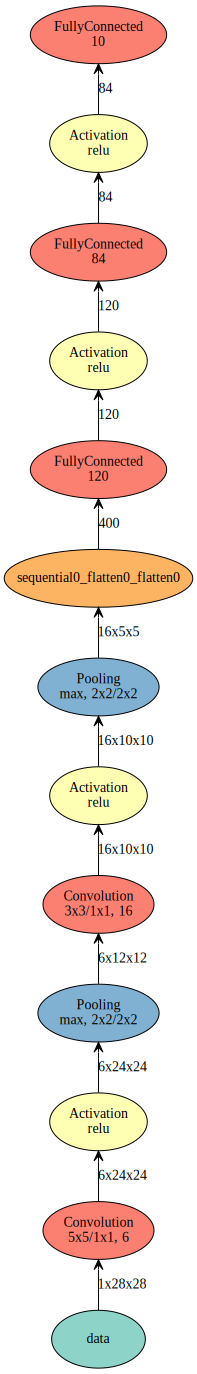

In [23]:
mx.viz.plot_network(net(mx.sym.var('data')), 
                    shape={"data":(1, 1, 28, 28)},
                    node_attrs={"shape":"oval","fixedsize":"False"},
                   )

### Run Network

The usage of `nn.Sequential` is similar to `nn.Dense` (both of them are subclasses of `nn.Block`). The following code shows how to initialize the weights and then run the forward pass. This example uses the default initializer. The input shape is 4 x 1 x 28 x 28 which represents a batch of 4 black and white images (i.e. 1 colour channel) of 28x28 pixels. Passing this through the neural network creates a 4 x 10 shaped output, which represents each of the 4 batches coupled with one of the 10 fashion categories.

In [24]:
net.initialize()

# Input shape is (batch_size, color_channels, height, width)
x = nd.random.uniform(shape=(4, 1, 28, 28))
y = net(x)
y.shape

(4, 10)

### Specific Layer

You can use `[]` to index a particular layer and access its attributes. For example, first you can view the structure of the neural network via `net`.

In [25]:
net

Sequential(
  (0): Conv2D(1 -> 6, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (2): Conv2D(6 -> 16, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (4): Flatten
  (5): Dense(400 -> 120, Activation(relu))
  (6): Dense(120 -> 84, Activation(relu))
  (7): Dense(84 -> 10, linear)
)

Below, you access the 1st layer's weight and 6th layer's bias.

In [26]:
"First Conv2D layer weight shape: {}, bias shape: {}".format(net[0].weight.data().shape, net[5].bias.data().shape)

'First Conv2D layer weight shape: (6, 1, 5, 5), bias shape: (120,)'

### Create a Neural Network Flexibly

In `nn.Sequential`, MXNet will automatically construct the forward function that sequentially executes added layers. Another way to construct a network is with a flexible forward function. This is a custom construct using the `Block` class. 

Create a subclass of `nn.Block` and implement two methods:

- `__init__`: Create the layers.
- `forward`: Define the forward function.

In [27]:
class MixMLP(nn.Block):
    def __init__(self, **kwargs):
        # Run `nn.Block`'s init method
        super(MixMLP, self).__init__(**kwargs)
        with self.name_scope():
            self.features = nn.Sequential()
            # Already within a name scope, no need to create
            # another scope.
            self.features.add(
                nn.Dense(3, activation='relu'),
                nn.Dense(4, activation='relu')
            )
            self.output = nn.Dense(5)
    def forward(self, x):
        y = self.features(x)
        print("Features", y)
        return self.output(y)

net2 = MixMLP()
net2

MixMLP(
  (features): Sequential(
    (0): Dense(None -> 3, Activation(relu))
    (1): Dense(None -> 4, Activation(relu))
  )
  (output): Dense(None -> 5, linear)
)

### Print Statements

In the sequential chaining approach, you can only add instances with `nn.Block` as the base class and then run them in a forward pass. In this example, you use `print` to get the intermediate results and `nd.relu` to apply relu activation. This approach provides a more flexible way to define the forward function.

Note that the usage of `net` is similar to before.

In [28]:
net2.initialize()

In [29]:
x = nd.random.uniform(shape=(2,2))
out = net2(x)

Features 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
<NDArray 2x4 @cpu(0)>


### Weight Access

Lastly, you can access a particular layer's weights.

In [30]:
net2.features[1].weight.data()


[[-0.02634858  0.05334064  0.02748809]
 [ 0.06669661 -0.01711474  0.01647211]
 [-0.04485548  0.00594983 -0.06654498]
 [ 0.04964591 -0.06058505  0.03413684]]
<NDArray 4x3 @cpu(0)>

## Automatic Differentiation with `autograd`
<a name="differentiation"></a>

Models are trained as a function of experience. Usually, getting better means minimizing a loss function. To achieve this goal, you often iteratively compute the gradient of the loss with respect to weights and then update the weights accordingly. While the gradient calculations are straightforward through a chain rule, working it out by hand can be painful for complex models.

Before diving deep into the model training, go through how MXNet’s `autograd` package expedites this work by automatically calculating derivatives.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

### Differentiate $f(x) = 2 x^2$ with Respect to Parameter, $x$

As an example, assume you are interested in differentiating a function $f(x) = 2 x^2$ with respect to parameter $x$. Start by assigning an initial value of $x$.

In [31]:
x = nd.array([[1, 2], [3, 4]])
x


[[1. 2.]
 [3. 4.]]
<NDArray 2x2 @cpu(0)>

Once you compute the gradient of $f(x)$ with respect to $x$, you will need a place to store it. In MXNet, you can tell an NDArray that you plan to store a gradient by invoking its `attach_grad()` method.

In [32]:
x.attach_grad()

### $y=f(x)$

Now define the function $y=f(x)$. To let MXNet store $y$, so that you can compute gradients later, you need to put the definition inside an `autograd.record()` scope.

In [33]:
def f(x):
    return 2 * x**2

with autograd.record():
    y = f(x)

x, y

(
 [[1. 2.]
  [3. 4.]]
 <NDArray 2x2 @cpu(0)>, 
 [[ 2.  8.]
  [18. 32.]]
 <NDArray 2x2 @cpu(0)>)

### Backward Propagation of $y$

Invoke back propagation (backprop) by calling `y.backward()`. When $y$ has more than one entry, `y.backward()` is equivalent to `y.sum().backward()`.

In [34]:
y.backward()

### $y=2x^2$  and $\frac{dy}{dx} = 4x$

Now check if this is the expected output. Note that $y=2x^2$ and $\frac{dy}{dx} = 4x$, which should be `[[4, 8],[12, 16]]`. Check the automatically computed results:

In [35]:
x, x.grad

(
 [[1. 2.]
  [3. 4.]]
 <NDArray 2x2 @cpu(0)>, 
 [[ 4.  8.]
  [12. 16.]]
 <NDArray 2x2 @cpu(0)>)

### Using Python Control Flows

You may want to write dynamic programs where the execution depends on some real-time values. MXNet will record the execution trace and compute the gradient as well.

Consider the following function $f$: it doubles the inputs until its `norm` reaches 1000. Then, it selects one element depending on the sum of its elements.

$Y=f(X)$
- Take a vector `X` of two random numbers in `[-1, 1]`.
- `X` is multiplied by `2` until its norm reaches `1000`.
- If `X`'s sum is positive, return the 1st element, otherwise return the 2nd.

In [36]:
def f(x):
    x = x * 2
    while x.norm().asscalar() < 1000:
        x = x * 2
    # If sum positive
    # pick 1st
    if x.sum().asscalar() >= 0:
        y = x[0]
    # else pick 2nd
    else:
        y = x[1]
    return y

Record the trace and feed in a random value:

In [37]:
x = nd.random.uniform(-1, 1, shape=2)
x


[-0.35996568  0.80884993]
<NDArray 2 @cpu(0)>

In [38]:
x.attach_grad()
with autograd.record():
    y = f(x)
y.backward()

### $y=k.x[0]$ or $y=k.x[1]$, hence $\frac{dy}{dx} =  \begin{vmatrix} 0 \\ k \end{vmatrix} $ or $ \begin{vmatrix} k \\ 0 \end{vmatrix}$

With $k = 2^n$ where $n$ is the number of times $x$ was multiplied by 2.

You know that $y$ is a linear function of $x$, and $y$ is chosen from $x$.

Thus, the gradient with respect to $x$ will be either `[y/x[0], 0]` or `[0, y/x[1]]`, depending on which element from $x$ was picked.

In [39]:
x


[-0.35996568  0.80884993]
<NDArray 2 @cpu(0)>

In [40]:
x.grad


[2048.    0.]
<NDArray 2 @cpu(0)>

___

# BREAK

Please pause here for a few minutes so we can come back together as a group to review important aspects of what you just accomplished in the above portion of this lab. The instructor will take approximately 5 minutes to review a few of these important aspects prior to you moving on to the final section of this lab.
___



## Train the Neural Network
<a name="train"></a>

In this section, you will learn how to train the previously defined network with data.

### Training Dataset: FashionMNIST

The handwritten digit MNIST dataset is one of the most commonly used datasets in deep learning. However, it is too simple to get a 99% accuracy. Here, you will use a similar but slightly more complicated dataset called FashionMNIST. The goal is no longer to classify numbers, but clothing types instead.

The dataset can be automatically downloaded through Gluon's `data.vision.datasets` module. The following code downloads the training dataset and shows the first example.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [41]:
mnist_train = datasets.FashionMNIST(train=True)
X, y = mnist_train[0]
print('X shape: %s dtype: %s' % (X.shape, X.dtype))
print("Number of images: %d" % len(mnist_train))

X shape: (28, 28, 1) dtype: <class 'numpy.uint8'>
Number of images: 60000


Each example in this dataset is a $28\times 28$ size grey image, which is presented as NDArray with the shape format of `(height, width, channel)`. The label is a `numpy` scalar.

Visualize the first six examples by running the code below.

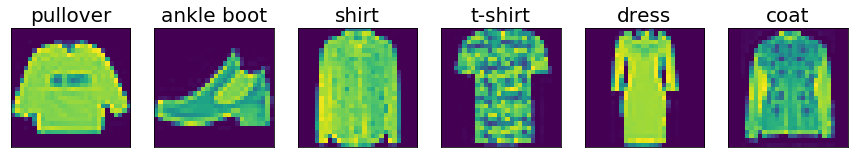

In [42]:
text_labels = [
    't-shirt', 'trouser', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
]

def plot_images(X, y):
    _, figs = plt.subplots(1, X.shape[0], figsize=(15, 15))
    for f,x,yi in zip(figs, X,y):
        f.imshow(x.reshape((28,28)).asnumpy())
        ax = f.axes
        ax.set_title(text_labels[int(yi)])
        ax.title.set_fontsize(20)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
X, y = mnist_train[0:6]
plot_images(X, y)

In order to feed data into a Gluon model, you need to convert the images to the `(channel, height, weight)` format with a floating-point data type. It can be done by `transforms.ToTensor`. In addition, normalize all pixel values using `transforms.Normalize` with a real mean of `0.13` and variance of `0.31`. Chain these two transforms together and apply it to the first element of the data pair, namely the images.

In [43]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

mnist_train = mnist_train.transform_first(transformer)

`FashionMNIST` is a subclass of `gluon.data.Dataset`, which defines how to get the `i`-th example. In order to use it in training, you need to get a (randomized) batch of examples. It can be easily done by `gluon.data.DataLoader`. Here, use four works to process data in parallel, which is often necessary especially for complex data transforms.

### Data Loading

Running the code cell below returns `train_data`, an iterator that yields batches of images and label pairs.

In [44]:
batch_size = 256

train_data = gluon.data.DataLoader(
    mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)

Next, create a validation dataset and data loader.

In [45]:
mnist_valid = gluon.data.vision.FashionMNIST(train=False)

valid_data = gluon.data.DataLoader(
    mnist_valid.transform_first(transformer),
    batch_size=batch_size, num_workers=4)

### Define the Model

Reimplement the same LeNet introduced before. One difference here is that you will change the weight initialization method to `Xavier`, which is a popular choice for deep convolutional neural networks.

In [46]:
net = nn.Sequential()
with net.name_scope():
    net.add(
        nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        nn.Dense(10)
    )
net.initialize(init=init.Xavier())

### Loss

Besides the neural network, you also need to define the loss function and optimization method for training. Use standard softmax cross entropy loss for classification problems. It first performs softmax on the output to obtain the predicted probability, and then compares the label with the cross entropy.

In [47]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

### Optimization

The optimization method selected is the standard stochastic gradient descent with a constant learning rate of `0.1`.

The `trainer` is created with all parameters (both weights and gradients) in `net`. Later on, you will only need to call the `step` method to update its weights.

In [48]:
trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': 0.1})

### Accuracy

To evaluate how good your model is, you need to compute both loss and accuracy. Loss relates to the number of errors made for the training and validation sets. Accuracy is a percentage describing how confident the model is in its prediction. To calculate this, sum the number of correctly predicted labels and divide by the total number of predictions. Higher accuracy is preferred. Loss is calculated via a Softmax Cross Entropy function which calculates the distance between predictions and true label. Lower loss is preferred.

In [49]:
def acc(output, label):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    acc = (output.argmax(axis=1) == label.astype('float32'))
    return acc.mean().asscalar()

### Training Loop

Now implement the complete training loop. The below should take around 2 minutes to complete on a m4.xlarge instance

In [50]:
for epoch in range(10):
    train_loss, train_acc, valid_acc = 0., 0., 0.
    tic = time()
    for data, label in train_data:
        # forward + backward
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        # update parameters
        trainer.step(batch_size)
        # calculate training metrics
        train_loss += loss.mean().asscalar()
        train_acc += acc(output, label)

    # calculate validation accuracy
    for data, label in valid_data:
        valid_acc += acc(net(data), label)

    print("Epoch %d: Loss: %.3f, Train acc %.3f, Test acc %.3f, \
Time %.1f sec" % (
        epoch, train_loss/len(train_data),
        train_acc/len(train_data),
        valid_acc/len(valid_data), time()-tic))

Epoch 0: Loss: 0.740, Train acc 0.726, Test acc 0.827, Time 9.9 sec
Epoch 1: Loss: 0.466, Train acc 0.825, Test acc 0.848, Time 10.1 sec
Epoch 2: Loss: 0.404, Train acc 0.850, Test acc 0.861, Time 10.4 sec
Epoch 3: Loss: 0.370, Train acc 0.863, Test acc 0.868, Time 10.0 sec
Epoch 4: Loss: 0.347, Train acc 0.870, Test acc 0.876, Time 10.1 sec
Epoch 5: Loss: 0.327, Train acc 0.878, Test acc 0.886, Time 10.1 sec
Epoch 6: Loss: 0.311, Train acc 0.885, Test acc 0.881, Time 10.0 sec
Epoch 7: Loss: 0.298, Train acc 0.888, Test acc 0.890, Time 10.4 sec
Epoch 8: Loss: 0.288, Train acc 0.893, Test acc 0.894, Time 10.3 sec
Epoch 9: Loss: 0.276, Train acc 0.897, Test acc 0.890, Time 10.1 sec


### Save the Model

Finally, save the trained parameters onto disk so that they can be used later.

In [51]:
"Validation accuracy: %.2f"%(valid_acc/len(valid_data))

'Validation accuracy: 0.89'

In [51]:
net.save_parameters('net.params')

## Predict with a Pre-Trained Model
<a name="predict"></a>

A saved model can be used in multiple places such as to continue training, to fine tune the model, and for prediction. In this section you will learn how to predict new examples using a pretrained model.

### Build the Model

To start, copy a simple model's definition.

<div style="text-align: right"><a href="#toc">Back to top</a></div>

In [52]:
net = nn.Sequential()
with net.name_scope():
    net.add(
        nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        nn.Dense(10)
    )

### Load Parameters

Load your saved parameters from the file `(net.params)` you saved previously.

In [53]:
net.load_parameters('net.params')

### Predict

Perform the same transformation you used for training, but this time for predicting.

In [54]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

Now try to predict the first six images in the validation dataset and store the predictions into `preds` and run through the neural network. Finally, visualize the images and compare the prediction with the truth. Note that in the output, the top label is the actual value (Truth) and the lower label is the predicted value.

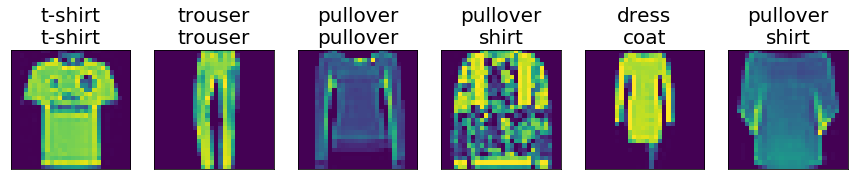

In [55]:
mnist_valid = datasets.FashionMNIST(train=False)
X, y = mnist_valid[:6]

preds = []  
for x in X:
    x = transformer(x).expand_dims(axis=0)
    pred = net(x).argmax(axis=1)
    preds.append(pred.astype('int32').asscalar())

def plot_images(X, y, preds):
    _, figs = plt.subplots(1, 6, figsize=(15, 15))
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat',
        'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ]
    for f,x,yi,pyi in zip(figs, X, y, preds):
        f.imshow(x.reshape((28,28)).asnumpy())
        ax = f.axes
        ax.set_title(text_labels[yi]+'\n'+text_labels[pyi])
        ax.title.set_fontsize(20)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    plt.close()
    
plot_images(X, y, preds)

### Predict with Models from the Gluon Model Zoo

The LeNet trained on FashionMNIST is a good example to start with, but too simple to predict real-life pictures. Instead of training a large-scale model from scratch, [Gluon Model Zoo](https://mxnet.incubator.apache.org/api/python/gluon/model_zoo.html) provides multiple, powerful pre-trained models.

For example, download and load a pre-trained ResNet-50 V2 model that was trained on the ImageNet dataset.

In [56]:
net = models.resnet50_v2(pretrained=True)

Also download and load the text labels for each class.

In [57]:
url = 'http://data.mxnet.io/models/imagenet/synset.txt'
fname = download(url)
with open(fname, 'r') as f:
    text_labels = [' '.join(l.split()[1:]) for l in f]
    
print(*text_labels[:10], sep='\n')

tench, Tinca tinca
goldfish, Carassius auratus
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
tiger shark, Galeocerdo cuvieri
hammerhead, hammerhead shark
electric ray, crampfish, numbfish, torpedo
stingray
cock
hen
ostrich, Struthio camelus


For this lab, a dog image was randomly picked from [Wikipedia](https://www.wikipedia.org/) as a test image.

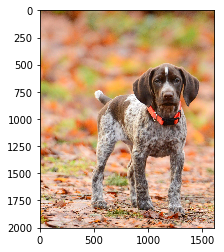

In [66]:
#fname = "golden_retriever.jpg"
#fname = "dog.jpeg"
fname = "bdog.jpg"
plt.imshow(plt.imread(fname))

### Preprocessing

The conventional method of preprocessing ImageNet data includes:

1. Resizing the short edge into 256 pixels.
1. Performing a center crop to obtain a 224-by-224 image.

The following code uses the image processing functions provided in the MXNet [`image` Module](https://mxnet.incubator.apache.org/api/python/image/image.html).

In [67]:
x = image.imread(fname)
x.shape

(2003, 1603, 3)

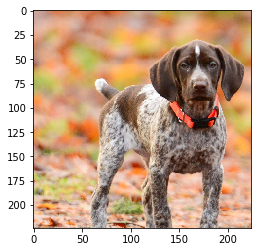

In [68]:
x = image.resize_short(x, 256)
x, _ = image.center_crop(x, (224,224))

plt.imshow(x.asnumpy())
plt.show()

You may already know it is an image of a Golden Retriever (you can also infer it from the image URL).

The further data transformation is similar to FashionMNIST except that you subtract the RGB means and divide by the corresponding variances to normalize each color channel.

After this, you can recognize the object in the image. Perform an additional softmax activation function on the output to obtain probability scores for the different types of objects, and then print the top-5 recognized objects.

In [69]:
def transform(data):
    data = data.transpose((2,0,1)).expand_dims(axis=0)
    rgb_mean = nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1))
    rgb_std = nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1))
    return (data.astype('float32') / 255. - rgb_mean) / rgb_std

output = net(transform(x))
pred = output.softmax()

idx = pred.topk(k=5).squeeze()
for i in idx:
    i = int(i.asscalar())
    print('With prob = %.5f, it contains %s' % (
        pred[0,i].asscalar(), text_labels[i]))

With prob = 0.99885, it contains German short-haired pointer
With prob = 0.00100, it contains bluetick
With prob = 0.00002, it contains Brittany spaniel
With prob = 0.00001, it contains vizsla, Hungarian pointer
With prob = 0.00001, it contains Walker hound, Walker foxhound


The model is highly confident the image contains a Golden Retriever.

# Lab Complete